# Comparing player shot with legue average

In [1]:
import pandas as pd
import numpy as np 
from nba_api.stats.static import players
from nba_api.stats.static import teams
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio
import seaborn as sns
import scipy.stats as st
pio.renderers.default='notebook'

## Draw court lines (dark mode)

In [2]:
#From: https://gitlab.com/jphwang/online_articles/-/blob/master/basketball_plots/
def draw_plotly_court(fig, fig_width=600, margins=10, layer='below'):
    
    # From: https://community.plot.ly/t/arc-shape-with-path/7205/5
    def ellipse_arc(x_center=0.0, y_center=0.0, a=10.5, b=10.5, start_angle=0.0, end_angle=2 * np.pi, N=200, closed=False):
        t = np.linspace(start_angle, end_angle, N)
        x = x_center + a * np.cos(t)
        y = y_center + b * np.sin(t)
        path = f'M {x[0]}, {y[0]}'
        for k in range(1, len(t)):
            path += f'L{x[k]}, {y[k]}'
        if closed:
            path += ' Z'
        return path

    fig_height = fig_width * (470 + 2 * margins) / (500 + 2 * margins)
    fig.update_layout(width=fig_width, height=fig_height)

    # Set axes ranges
    fig.update_xaxes(range=[-250 - margins, 250 + margins])
    fig.update_yaxes(range=[-52.5 - margins, 417.5 + margins])

    threept_break_y = 89.47765084
    orange = "#ec7607"
    line_color = "#c7c3bf"
    three_line_col, main_line_col = line_color, line_color

    fig.update_layout(
        # Line Horizontal
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="black",
        plot_bgcolor="black",
        yaxis=dict(
            scaleanchor="x",
            scaleratio=1,
            showgrid=False,
            zeroline=False,
            showline=False,
            ticks='',
            showticklabels=False,
            fixedrange=True,
        ),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            ticks='',
            showticklabels=False,
            fixedrange=True,
        ),
        shapes=[
            dict(
                type="rect", x0=-250, y0=-52.5, x1=250, y1=417.5,
                line=dict(color=main_line_col, width=1),
                # fillcolor='#333333',
                layer=layer
            ),
            dict(
                type="rect", x0=-80, y0=-52.5, x1=80, y1=137.5,
                line=dict(color=main_line_col, width=1),
                # fillcolor='#333333',
                layer=layer
            ),
            dict(
                type="rect", x0=-60, y0=-52.5, x1=60, y1=137.5,
                line=dict(color=main_line_col, width=1),
                # fillcolor='#333333',
                layer=layer
            ),
            dict(
                type="circle", x0=-60, y0=77.5, x1=60, y1=197.5, xref="x", yref="y",
                line=dict(color=main_line_col, width=1),
                # fillcolor='#dddddd',
                layer=layer
            ),
            dict(
                type="line", x0=-60, y0=137.5, x1=60, y1=137.5,
                line=dict(color=main_line_col, width=1),
                layer=layer
            ),

            dict(
                type="rect", x0=-2, y0=-7.25, x1=2, y1=-12.5,
                line=dict(color=line_color, width=1),
                fillcolor=line_color,
            ),
            dict(
                type="circle", x0=-7.5, y0=-7.5, x1=7.5, y1=7.5, xref="x", yref="y",
                line=dict(color=line_color, width=1),
            ),
            dict(
                type="line", x0=-30, y0=-12.5, x1=30, y1=-12.5,
                line=dict(color=line_color, width=1),
            ),

            dict(type="path",
                 path=ellipse_arc(a=40, b=40, start_angle=0, end_angle=np.pi),
                 line=dict(color=main_line_col, width=1), layer=layer),
            dict(type="path",
                 path=ellipse_arc(a=237.5, b=237.5, start_angle=0.386283101, end_angle=np.pi - 0.386283101),
                 line=dict(color=main_line_col, width=1), layer=layer),
            dict(
                type="line", x0=-220, y0=-52.5, x1=-220, y1=threept_break_y,
                line=dict(color=three_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=-220, y0=-52.5, x1=-220, y1=threept_break_y,
                line=dict(color=three_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=220, y0=-52.5, x1=220, y1=threept_break_y,
                line=dict(color=three_line_col, width=1), layer=layer
            ),

            dict(
                type="line", x0=-250, y0=227.5, x1=-220, y1=227.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=250, y0=227.5, x1=220, y1=227.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=-90, y0=17.5, x1=-80, y1=17.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=-90, y0=27.5, x1=-80, y1=27.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=-90, y0=57.5, x1=-80, y1=57.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=-90, y0=87.5, x1=-80, y1=87.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=90, y0=17.5, x1=80, y1=17.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=90, y0=27.5, x1=80, y1=27.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=90, y0=57.5, x1=80, y1=57.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),
            dict(
                type="line", x0=90, y0=87.5, x1=80, y1=87.5,
                line=dict(color=main_line_col, width=1), layer=layer
            ),

            dict(type="path",
                 path=ellipse_arc(y_center=417.5, a=60, b=60, start_angle=-0, end_angle=-np.pi),
                 line=dict(color=main_line_col, width=1), layer=layer),

        ]
    )
    return True

# test = go.Figure()
# draw_plotly_court(test)
# test

#### Get shot chart info for Kawhi Leanords 2018-2019 season

In [3]:
def get_player_shotchartdetail(player_name, season_id):
    # player id
    player_id = players.find_players_by_full_name(player_name)[0]['id']
    
    # career df
    career_df = playercareerstats.PlayerCareerStats(player_id=player_id).get_data_frames()[0]
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_id), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

# Get shot chart info for Kawhi Leanords 2018-2019 season
player = 'Kawhi Leonard'
season = '2018-19'
player_shotchart_df, league_avg = get_player_shotchartdetail(player, season)

### Getting Team Shot Data and Creating Shot Chart

In [4]:
def get_team_shotchartdetail(team_name, season_id):
    # team id during the season
    team_id = teams.find_teams_by_full_name(team_name)[0]['id']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=0, 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

# Get Toronto Raptors 2018-19 season shot chart
# team_name= 'Toronto Raptors'
# team_shotchart_df, team_league_avg = get_team_shotchartdetail(team_name, season)

## Hexbin that compares player/team with legue average

1129


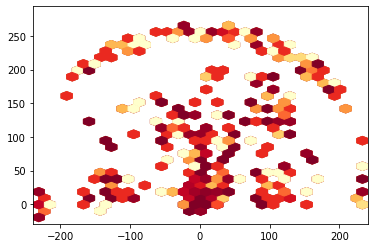

In [11]:
def make_player_vs_legue_hexbin(fig, shots_df,league_avg,in_type,name,season_id):
    
    grid_size= 30 
    min_show = max(1, round(len(shots_df)* 0.001)) # min count for shots in hex
    
    x_loc = []
    y_loc = []
    y_limit = 300

    for y in range(len(shots_df['LOC_Y'])):
        if shots_df['LOC_Y'][y] < y_limit:
            y_loc.append(shots_df['LOC_Y'][y])
            x_loc.append(shots_df['LOC_X'][y])
    
    
    Hex = plt.hexbin(x=x_loc, y=y_loc,gridsize=grid_size,vmin = 0.0, vmax = 0.7,
    cmap=plt.get_cmap('YlOrRd'), mincnt= min_show + 1)

    # join shotchart with legue average
    la_basic = league_avg['SHOT_ZONE_BASIC']
    la_area = league_avg['SHOT_ZONE_AREA']
    la_range = league_avg['SHOT_ZONE_RANGE']
    la_fg_pct = league_avg['FG_PCT']
    la_fg_pct_player = []
    shot_l = len(shots_df)
    la_l = len(league_avg)

    
    for i in range(shot_l):
        for j in range(la_l):
            if shots_df['SHOT_ZONE_BASIC'][i] == la_basic[j] and \
                shots_df['SHOT_ZONE_AREA'][i] == la_area[j] and \
                shots_df['SHOT_ZONE_RANGE'][i] == la_range[j]:
                la_fg_pct_player.append(la_fg_pct[j])
                break

    # Make hex distribution of the legue average FG % 
    HexL = plt.hexbin(x=x_loc, y=y_loc, C=la_fg_pct_player,gridsize=grid_size, vmin = 0.0, vmax = 0.7, 
    cmap=plt.get_cmap('YlOrRd'), mincnt=min_show)

    # Make hex distribution of the palyer FG % 
    HexC = plt.hexbin(x=x_loc, y=y_loc, C=shots_df['SHOT_MADE_FLAG'],gridsize=grid_size, vmin = 0.0, vmax = 0.7, 
    cmap=plt.get_cmap('YlOrRd'), mincnt=min_show)

    # Extract data from hexbins
    loc = HexC.get_offsets()
    acc = HexC.get_array()
    la_acc = HexL.get_array()
    shots = Hex.get_array()

    xlocs = []
    ylocs = []
    accs_by_hex = []
    la_accs_by_hex = []
    diff_by_hex = []
    shots_by_hex = []
    hex_size = []

    for i in range(len(loc)):
        xlocs.append(loc[i][0])
        ylocs.append(loc[i][1])
        accs_by_hex.append(acc[i])
        la_accs_by_hex.append(la_acc[i])
        diff_by_hex.append(acc[i] - la_acc[i])
        shots_by_hex.append(shots[i])

    #freq is % of total shots
    freq_by_hex = list(map(lambda x: x/len(shots_df), shots_by_hex))
    hex_size = list(map(lambda x: x * 4, freq_by_hex))

    if in_type == 'p':
        hexbin_text = [
            '<i>Legue FG: </i>' + str(round(la_accs_by_hex[i]*100, 1)) + '%<BR>'
            '<i>Player FG: </i>' + str(round(accs_by_hex[i]*100, 1)) + '%<BR>'
            '<i>Difference: </i>' + str(round(diff_by_hex[i]*100, 1)) + '%<BR>'
            '<i>Frequency: </i>' + str(round(freq_by_hex[i]*100, 2)) + '%'
            for i in range(len(freq_by_hex))
        ]
        
    elif in_type == 't':
        hexbin_text = [
            '<i>Legue FG: </i>' + str(round(la_accs_by_hex[i]*100, 1)) + '%<BR>'
            '<i>Team FG: </i>' + str(round(accs_by_hex[i]*100, 1)) + '%<BR>'
            '<i>Difference: </i>' + str(round(diff_by_hex[i]*100, 1)) + '%<BR>'
            '<i>Frequency: </i>' + str(round(freq_by_hex[i]*100, 2)) + '%'
            for i in range(len(freq_by_hex))
        ]
        
    max_val = max(diff_by_hex) - max(diff_by_hex) * 0.2
    min_val = min(diff_by_hex)
    fig.add_trace(go.Scatter(x=xlocs, y=ylocs, mode='markers', name='markers', 
                        marker=dict(size=hex_size, sizemode='area', sizeref= 2. * max(hex_size) / (18. ** 2), 
                                    sizemin=4.5,color=diff_by_hex, colorscale="RdYlBu",line=dict(width=1, color='white'),reversescale=True,
                                    colorbar=dict(thickness=15, x=0.84,y=0.87, yanchor='middle',len=0.2,
                                                    title=dict(text="<B>Difference</B>",font=dict(size=11,color='white')),
                                                    tickvals=[max_val, 0, min_val], 
                                                    ticktext=["Better", "On par", "Worse"]),
                                    symbol='hexagon'), text=hexbin_text, hoverinfo='text'))

    fig.update_layout(
        title={
            'text': f"{name} {season_id} Hex Shot Map in relation with legue average",
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
            },
         font=dict(color="white"))
    
    draw_plotly_court(fig)
  

# Comparing player shot with legue average
kawhi_hexbin = go.Figure()
make_player_vs_legue_hexbin(kawhi_hexbin,player_shotchart_df,league_avg,'p','Kawhi Leonard', '2018-19')
kawhi_hexbin.show(config=dict(displayModeBar=False))

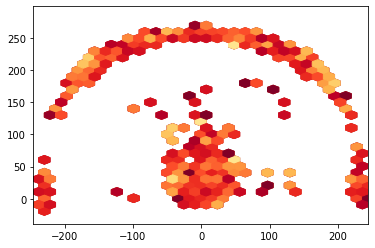

In [10]:
# Comparing team shot with legue average
team_hexbin = go.Figure()
team_name= 'Toronto Raptors'
team_shotchart_df, team_league_avg = get_team_shotchartdetail(team_name, season)

make_player_vs_legue_hexbin(team_hexbin,team_shotchart_df,team_league_avg,'t',team_name, '2018-19')
team_hexbin.show(config=dict(displayModeBar=False))